In [17]:
%load_ext autoreload
%autoreload 2

import sys
import os
sys.path.append('../')

# Graph imports
import src.graph as graph
import src.estimator as estimator
import src.utils as utils
import src.model_selection as model_selection

# usual imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import gc
import random
import networkx as nx

from IPython.display import display
from pyvis.network import Network

import pickle
import os

np.random.seed(42)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Simple test

In [5]:
np.random.seed(42)  # Seed for reproducibility
real_graph = nx.gnp_random_graph(100, 0.05)  # G(n,p) model with 100 nodes and a probability of edge creation of 0.05

In [6]:
# Simulate a logistic graph model (another random graph, for demonstration purposes)
logit_graph = nx.gnp_random_graph(100, 0.05)

In [8]:
# Importing the necessary class
import src.model_selection as ms 

# Initialize the RandomGraphModelSelector
selector = ms.RandomGraphModelSelector(real_graph = real_graph, logit_graph = logit_graph)

# Fit models and find the best model
best_model, model_scores = selector.fit()
print(f"The best model is: {best_model}")
print("Model scores:")
for model, score in model_scores.items():
    print(f"{model}: {score}")


ER
For the Graph with 100 nodes and 239 edges i get the following scores: ks_stat: 0.12, cc_diff: 0.00879725829725829, aspl_diff: 0.21313131313131306

WS
For the Graph with 100 nodes and 200 edges i get the following scores: ks_stat: 0.54, cc_diff: 0.3888455988455989, aspl_diff: 3.9240404040404036

BA
For the Graph with 100 nodes and 475 edges i get the following scores: ks_stat: 0.38, cc_diff: 0.15627091881741598, aspl_diff: 0.6963636363636363

LG
For the Graph with 100 nodes and 233 edges i get the following scores: ks_stat: 0.15, cc_diff: 0.011798701298701288, aspl_diff: 0

The best model is: LG
Model scores:
ER: 0.34192857142857136
WS: 4.852886002886002
BA: 1.2326345551810522
LG: 0.16179870129870128


# Celegans

In [18]:
import graph_tool.all as gt
from graph_tool.all import *

model = "celegans_2019/male_gap_junction" # undirected graph
g_celegans = gt.collection.ns[model]
g_celegans = adjacency(g_celegans)

spec_g_celegans = graph.GraphModel.calculate_spectrum(g_celegans)

In [25]:
est = estimator.LogitRegEstimator2(g_celegans)
params, pval = est.estimate_parameters()
sigma,alpha,beta = params

                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:               170853
Model:                          Logit   Df Residuals:                   170850
Method:                           MLE   Df Model:                            2
Date:                Mon, 15 Apr 2024   Pseudo R-squ.:                  0.1289
Time:                        13:53:25   Log-Likelihood:                -8511.9
converged:                       True   LL-Null:                       -9771.8
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -5.9638      0.043   -137.522      0.000      -6.049      -5.879
x1             0.0844      0.002     46.396      0.000       0.081       0.088
x2             0.0743      0.002     38.430      0.0

## Gen graph with the same parameters

In [26]:
# beta should be higher than c
n = g_celegans.shape[0]
p = 0
alpha = alpha   #  negative 0.003
beta  = beta    #  negative the higher the more concentrated will be the edges into a single vertex 0.003
sigma = sigma    # intercept the higher the harder for creating edges 6
threshold   = 0.5
n_iteration = 10
warm_up     = 5
params_dict = {
    "n": n,
    "p": p,
    "alpha": alpha,
    "beta": beta,
    "sigma": sigma,
    "threshold": threshold,
    "n_iteration": n_iteration,
    "warm_up": warm_up
}

In [27]:
graph = graph.GraphModel(**params_dict)
graphs, spec = graph.populate_edges( warm_up = warm_up, max_iterations = n_iteration)

iteration: 0
iteration: 1
iteration: 2
iteration: 3
iteration: 4
iteration: 5
iteration: 6
KS Statistic: 0.0547008547008547
Degree Distribution Stable: False
Graph Converged: False




iteration: 7
KS Statistic: 0.046153846153846156
KS Statistic: 0.0547008547008547
Degree Distribution Stable: False
Graph Converged: False




iteration: 8
KS Statistic: 0.03418803418803419
KS Statistic: 0.046153846153846156
KS Statistic: 0.0547008547008547
Degree Distribution Stable: False
Graph Converged: False




iteration: 9
KS Statistic: 0.011965811965811967
KS Statistic: 0.03418803418803419
KS Statistic: 0.046153846153846156
KS Statistic: 0.0547008547008547
Degree Distribution Stable: False
Graph Converged: False






In [28]:
ut = utils.GraphUtils()
ut.saving_graph_artifacts(params_dict, graphs, spec)
#graphs, spec = ut.loading_graph_artifacts(params_dict)

../data/input/graph_data_n=585_p=0_alpha=-0.0843557889967107_beta=-0.07429414968441728_sigma=5.963769941679803_threshold=0.5_n_iteration=10_warm_up=5.pickle
../data/input/spec_data_n=585_p=0_alpha=-0.0843557889967107_beta=-0.07429414968441728_sigma=5.963769941679803_threshold=0.5_n_iteration=10_warm_up=5.pickle


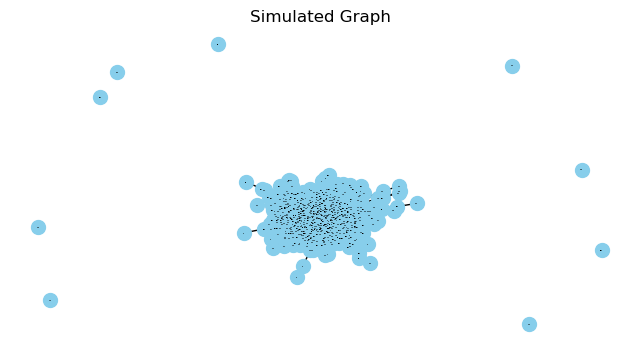

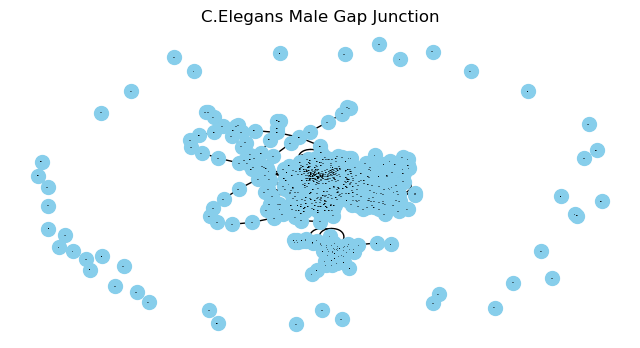

In [29]:
g = graphs[-1]
s = spec[-1]

fig1 = ut.plot_graph_from_adjacency(adj_matrix=g, pos=None, title='Simulated Graph', size=(8, 4), node_size=100, font_size=1)
fig2 = ut.plot_graph_from_adjacency(adj_matrix=g_celegans, pos=None, title='C.Elegans Male Gap Junction', size=(8, 4), node_size=100, font_size=1)

## Model Selections

In [38]:
import src.model_selection as ms 
real_graph = nx.from_numpy_array(g_celegans.toarray())
logit_graph = nx.from_numpy_array(g)

selector = ms.RandomGraphModelSelector(real_graph = real_graph, logit_graph = logit_graph)

# Fit models and find the best model
best_model, model_scores = selector.fit()
print(f"The best model is: {best_model}")
print("Model scores:")
for model, score in model_scores.items():
    print(f"{model}: {score}")


ER
For the Graph with 585 nodes and 1731 edges i get the following scores: ks_stat: 0.30256410256410254, cc_diff: 0.19588573265730208, aspl_diff: 0

WS
For the Graph with 585 nodes and 1170 edges i get the following scores: ks_stat: 0.452991452991453, cc_diff: 0.2831992327097146, aspl_diff: 0

BA
For the Graph with 585 nodes and 3474 edges i get the following scores: ks_stat: 0.6547008547008547, cc_diff: 0.14952184798662754, aspl_diff: 0

LG
For the Graph with 585 nodes and 1229 edges i get the following scores: ks_stat: 0.1794871794871795, cc_diff: 0.19820339125701197, aspl_diff: 0

The best model is: LG
Model scores:
ER: 0.4984498352214046
WS: 0.7361906857011675
BA: 0.8042227026874822
LG: 0.37769057074419143


In [43]:
import src.model_selection as ms 
real_graph = nx.from_numpy_array(g_celegans.toarray())
logit_graph = nx.from_numpy_array(g)

selector = ms.ModelSelectorSpectrum(real_graph = real_graph, logit_graph = logit_graph)

# Fit models and find the best model
best_model, model_scores = selector.fit()
print(f"The best model is: {best_model}")
print("Model scores:")
for model, score in model_scores.items():
    print(f"{model}: {score}")


The best model is: ER
Model scores:
ER: 3.7900075023820863
WS: 13.666159914795811
BA: 27.29001233175682
LG: 3.819704267074205
